In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [356]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [3]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [693]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_b = sps.firwin(49, 100000/freq_hz)
f_slpf_a = [1.0]
f_slpf_offset = 24

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24

# This does the *real* work of detecting syncs...

f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [778]:
infd = open('rotplane.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]

bpfdata = sps.lfilter(f_burst_bpf_b, f_burst_bpf_a, data)[f_lpf_offset:]

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
data_despike = data.copy()
data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)

slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data_despike)[f_slpf_offset:]
sdata = slpfdata < synctrig

sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
# Clip sfdata so there are no false low peaks
sfdata[np.where(sfdata < .05)] = .05



In [779]:

def inrange(x, mi, ma):
    return (x >= mi) and (x <= ma)

def inrange_fsc(x, mi, ma):
    xf = x / FSC
    return (xf >= mi) and (xf <= ma)


In [780]:
# This is a (seemingly) reliable indicator of a VSYNC transition - or possibly *severe* rot.
invsync = sfdata > 0.6
# Catch the edges, and add one to the results to easily determine rising/falling edges
vsync_boundary = (np.where(np.diff(invsync))[0]) + 1

fields = []

for v in range(0, len(vsync_boundary)):
    if invsync[vsync_boundary[v]]: # Rising edge found
        
        # Determine % of sync before sync start
        
        vb = vsync_boundary[v]
        # Rewind to the previous trough for more accurate measurement
        presync = vb - int(140 * FSC) + np.argmin(sfdata[vb - int(80 * FSC): vb])
        presync_sum = np.sum(sfdata[presync - int(227.5 * FSC * 4.25): presync])
#        print(v, vsync_boundary[v], presync_sum, end = ' ')

        # Find the end of VSYNC - with debounce protection (using regular end of VSYNC - ~66x FSC)
        for v2 in range(v + 1, len(vsync_boundary)):
            ve = vsync_boundary[v2]
            gap = vsync_boundary[v2] - vsync_boundary[v]

            if invsync[ve] == False and inrange_fsc(gap, 650, 670):
                postsync = ve + np.argmin(sfdata[ve:ve + int(80 * FSC)])
                postsync_sum = np.sum(sfdata[postsync: postsync + int(227.5 * FSC * 4.25)])

#                print(postsync_sum, presync_sum + postsync_sum)
                
                fields.append((postsync, presync_sum > postsync_sum))

print(fields)

[(106068, True), (583818, False), (1061805, True), (1539689, False), (2017234, True), (2494987, False), (2972986, True), (3450871, False), (3928412, True), (4406173, False), (4884176, True), (5362064, False), (5839611, True), (6317390, False), (6795372, True), (7273237, False), (7750781, True), (8228570, False), (8706567, True), (9184424, False), (9661955, True), (10139736, False), (10617752, True), (11095622, False)]


In [781]:
# Previously written color burst detection

# set up sync color heterodyne table first 
out_fsc = 8
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))
    obhet_angles = np.angle(obhet_filt)

    level = np.amax(obhet_levels)
    phase = obhet_angles[np.argmax(obhet_levels)]
        
    return [level, phase]
    
def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

    

(458640,)
uint8 (504, 910) (504, 910)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


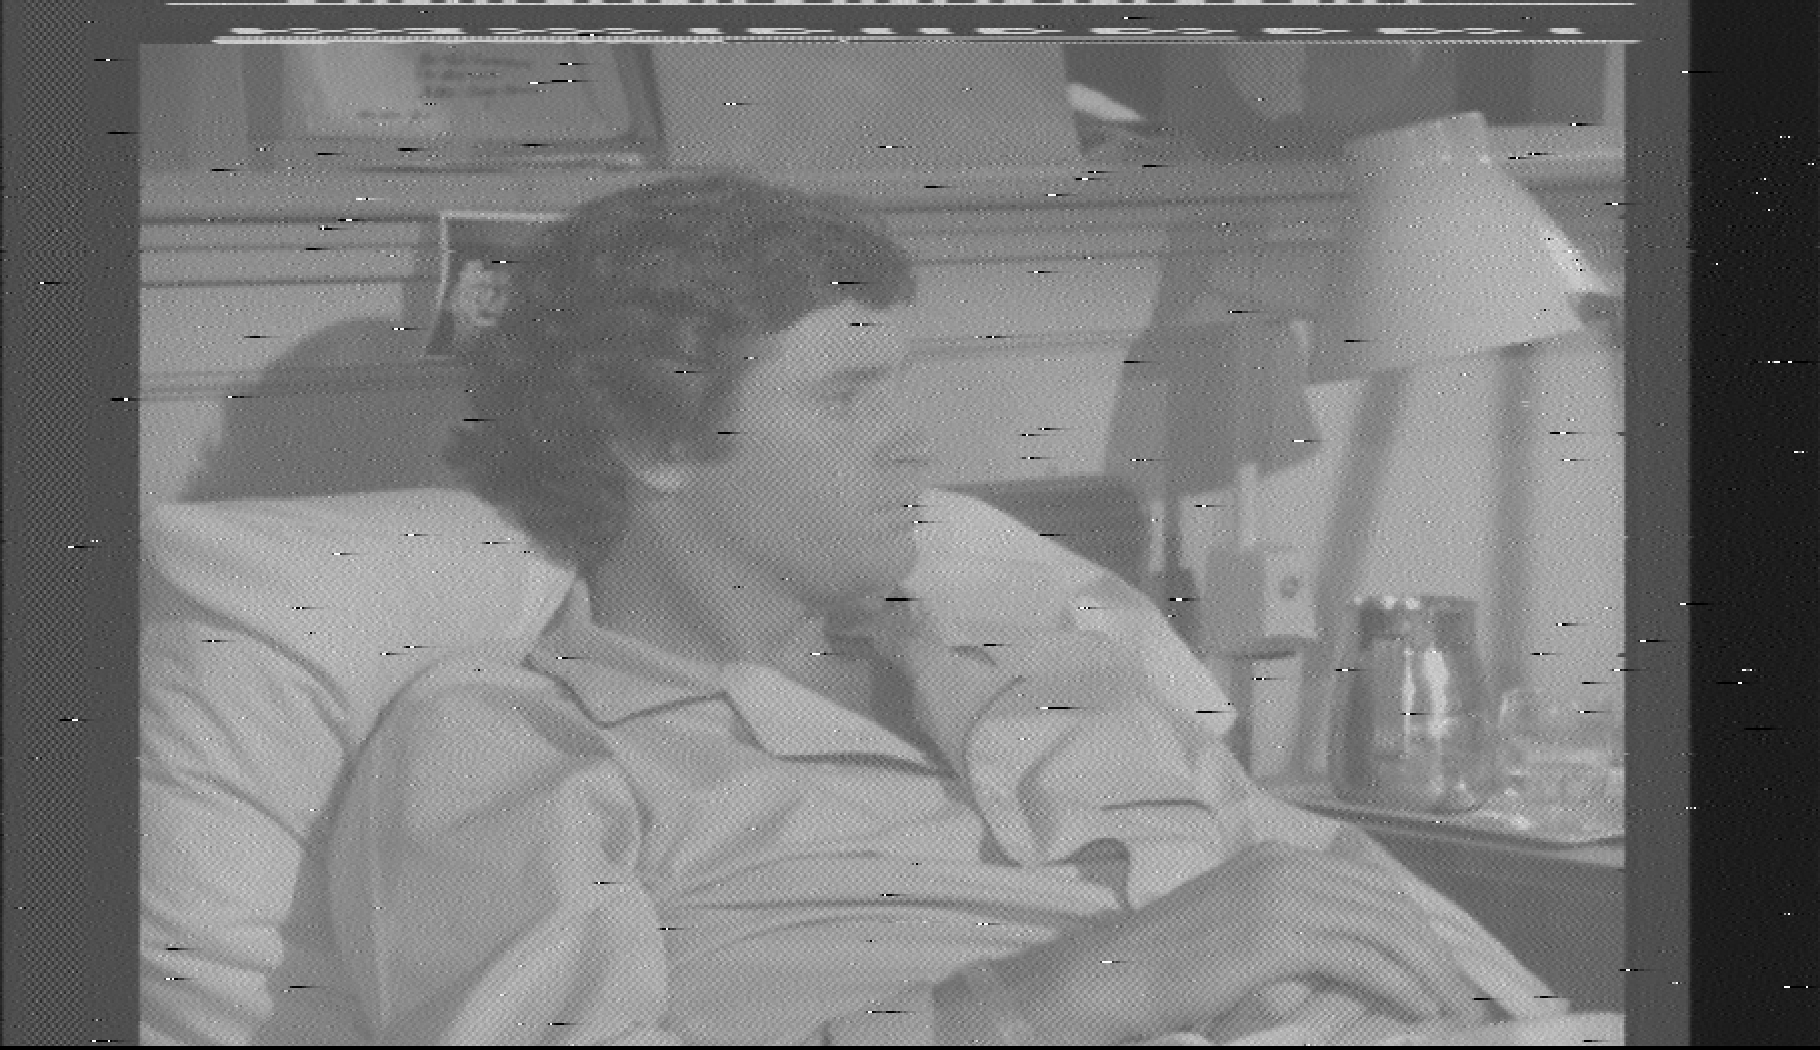

In [783]:
framebuf = np.zeros(910 * 504, dtype=np.uint16)
lineloc = np.zeros((504, 2), dtype=np.float32)

fnum = -1
sf = 0
for f in range(sf+2, sf + 8):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
        
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    subset = sfdata[begin:begin + int(FSC * 227.5 * 255)]
    peaksr = np.logical_and((subset[1:-1] > subset[2:]), (subset[1:-1] > subset[:-2]))
    peaks = np.where(peaksr)[0].astype(np.float64)

    lbegin = np.zeros(253, dtype=np.float64)
    lend = np.zeros(253, dtype=np.float64)
    
    avg = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)

    adjust = np.zeros(253, dtype=np.float32)
    
    tgt = -1
    lasterr = -2
    for line in range(0, 253):
        lbegin_subset = slpfdata[begin + peaks[line]: begin + peaks[line] + (10 * FSC)]
        
        curlbegin = np.where(lbegin_subset > IREToRaw(-20))[0][0]
        curlbegin = curlbegin - (lbegin_subset[curlbegin] - IREToRaw(-20)) / (lbegin_subset[curlbegin] - lbegin_subset[curlbegin - 1])
        #curlbegin += begin + peaks[line]

        dsub = lpfdata[begin + peaks[line] + curlbegin - (10 * FSC):begin + peaks[line] + curlbegin + (10 * FSC)]
        if (np.min(dsub) < IREToRaw(-45) or np.max(dsub) > IREToRaw(10)) or(curlbegin < 55) or (curlbegin > 58) and (line > 2):
            lbegin[line] = lbegin[line - 1] + (lbegin[line - 1] - lbegin[line - 2])
        else:
            lbegin[line] = peaks[line] + curlbegin
            
#        if line >= 1:
#            lend[line - 1] = lbegin[i]

    nextcb = (1920 / 1820)
    o1 = {}
            
    for line in range(0, 251): # ignore the last line (for now?) since it might need to be special-cased
        if line > 1:
            avg[1:] = avg[:-1]
            avg[0] = lbegin[line] - lbegin[line - 1]
            
        linelen = lbegin[line + 1] - lbegin[line]
        
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        burst = burst_detect(sline1[20:100])
        burst2 = burst_detect(sline1[1836:1920])
        #print(line, burst[1], burst2[1])
        
        if line < 5:
            tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        else:
            tgt = 0 if np.fabs(tgt) == np.pi else np.pi
                        
        adjust[line] = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        adjust[line + 1] = -1.00 * phasemult * wrap_angle(burst[1], burst2[1])
        
        lbegin[line] += adjust[line]
        lend[line] = lbegin[line + 1] + adjust[line] + adjust[line + 1]

        linelen = lend[line] - lbegin[line]
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        burst = burst_detect(sline1[20:100])
        burst2 = burst_detect(sline1[1836:1920])
        #o1[line] = (burst[1], burst2[1])
        
        #print(line, burst[1], burst2[1])

        adjust[line + 1] = -1.00 * phasemult * wrap_angle(burst[1], burst2[1])
        lend[line] += adjust[line + 1]
        
        linelen = lend[line] - lbegin[line]
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        burst = burst_detect(sline1[20:100])
        burst2 = burst_detect(sline1[1836:1920])

#        if np.fabs(wrap_angle(tgt, burst2[1])) > .2:
        #print(line, burst[1], burst2[1])


    lend[251] = lbegin[251]
        
    for line in range(0, 251):    
        
        if None: # line < 250:
            slinet = scale(data[begin:], lbegin[line], lbegin[line + 2], 3640)
            burst1 = burst_detect(slinet[20:100])
            burst2 = burst_detect(slinet[1840:1920])
        
            print(line, o1[line], burst1[1], burst2[1])

        sline = scale(data[begin:], lbegin[line], lend[line], 910)
            
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break

drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


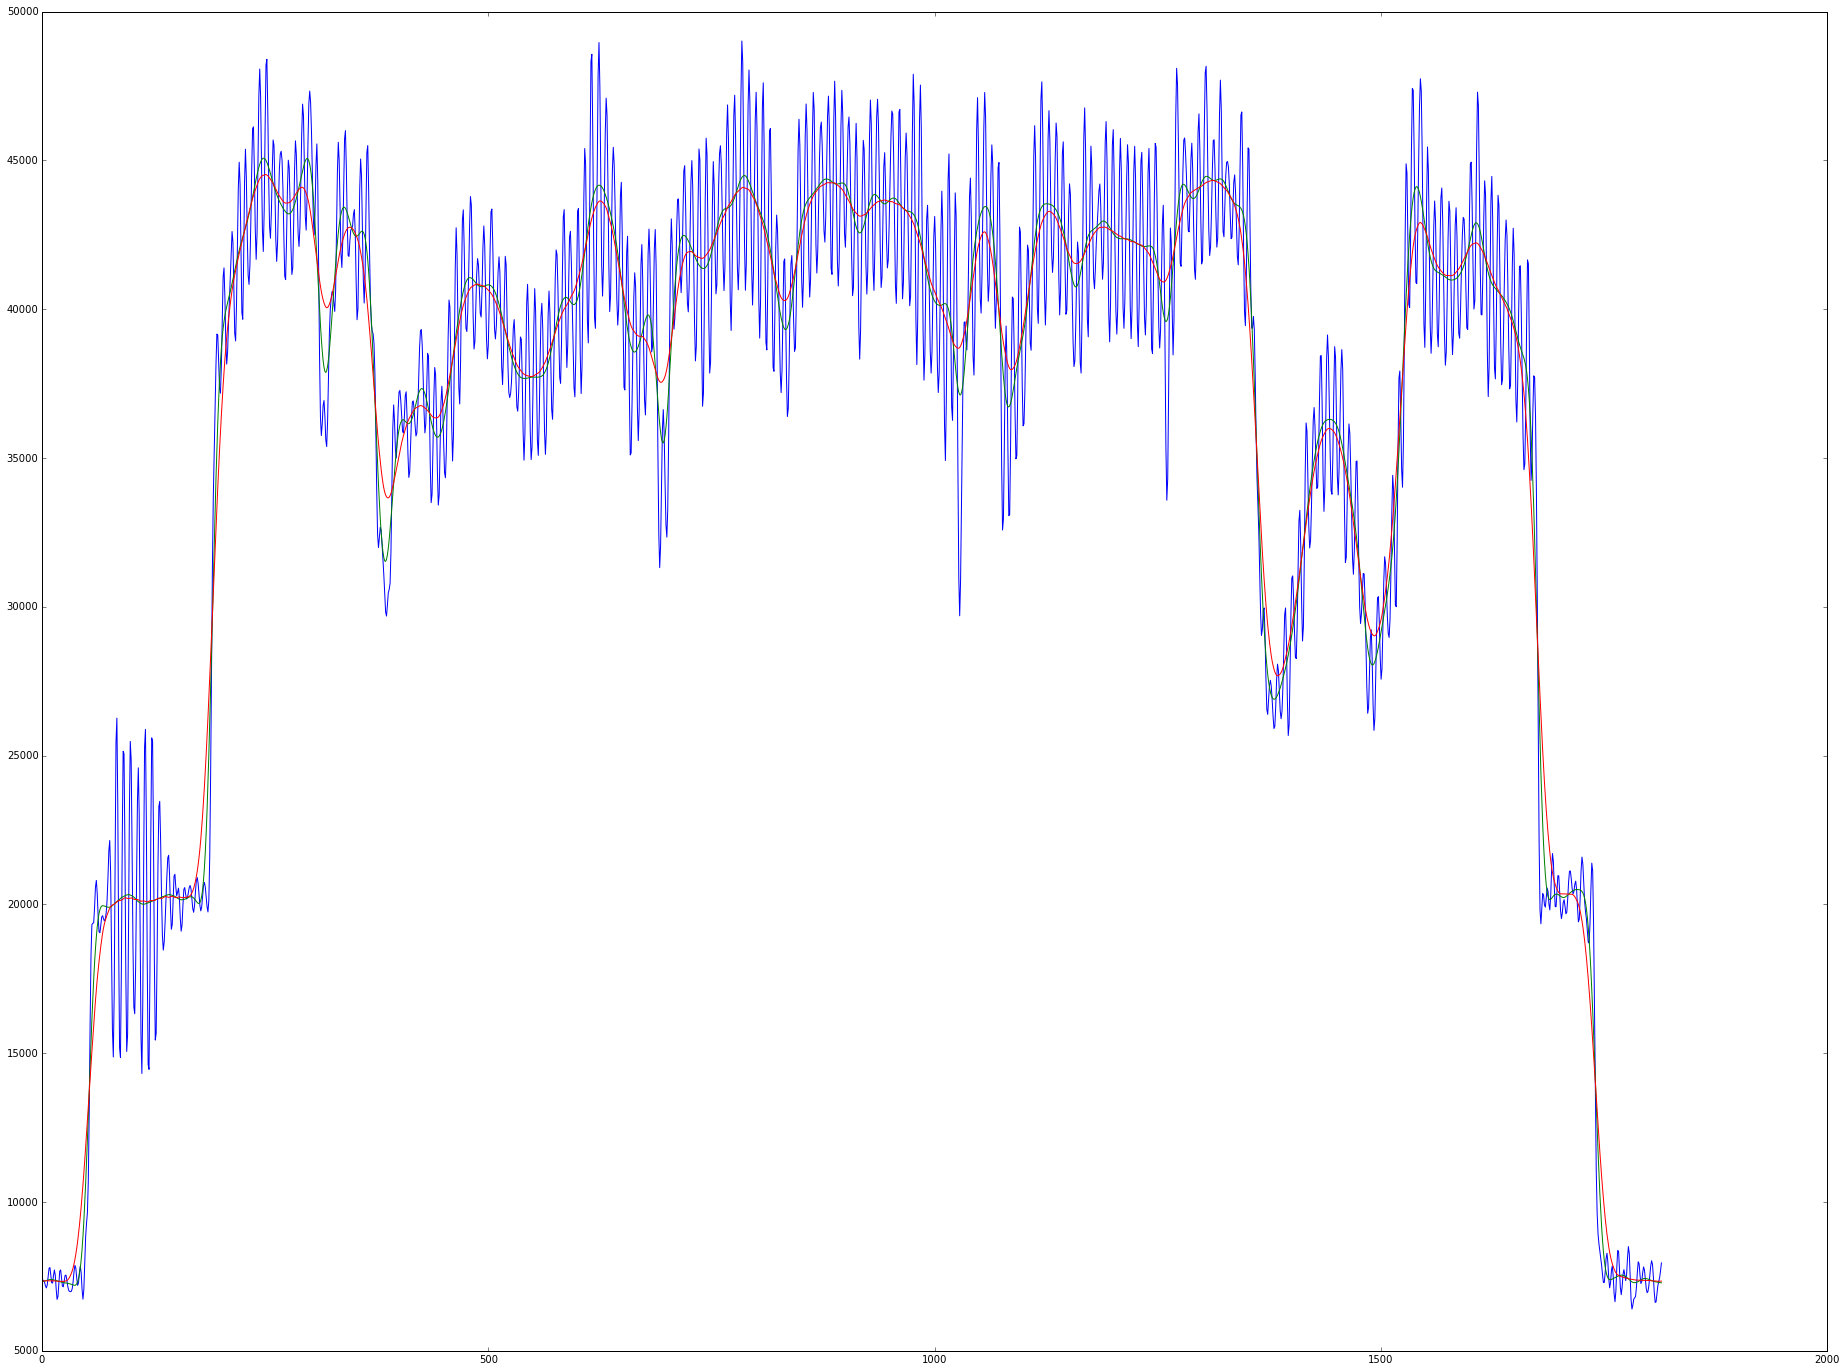

In [607]:
l = 194
plt.plot(data[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(lpfdata[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(slpfdata[begin + peaks[l]:begin + peaks[l + 1]])

In [616]:
lbegin_subset[50:60], np.where(lbegin_subset > IREToRaw(-20))[0][0]

(array([ 10414.10435761,  10792.34360403,  11191.98285168,  11608.71844003,
         12038.29851903,  12477.56647442,  12925.32640552,  13382.06699203,
         13848.04667767,  14320.7816233 ]), 57)

In [620]:
offset = (lbegin_subset[57] - IREToRaw(-20)) / (lbegin_subset[57] - lbegin_subset[56])
57 - offset

56.395571577861446

In [621]:
IREToRaw(-20)

13106

In [683]:
burst_detect(data[bbegin:bend])

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


[1999.4635513324383, -1.4960407277783672]

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


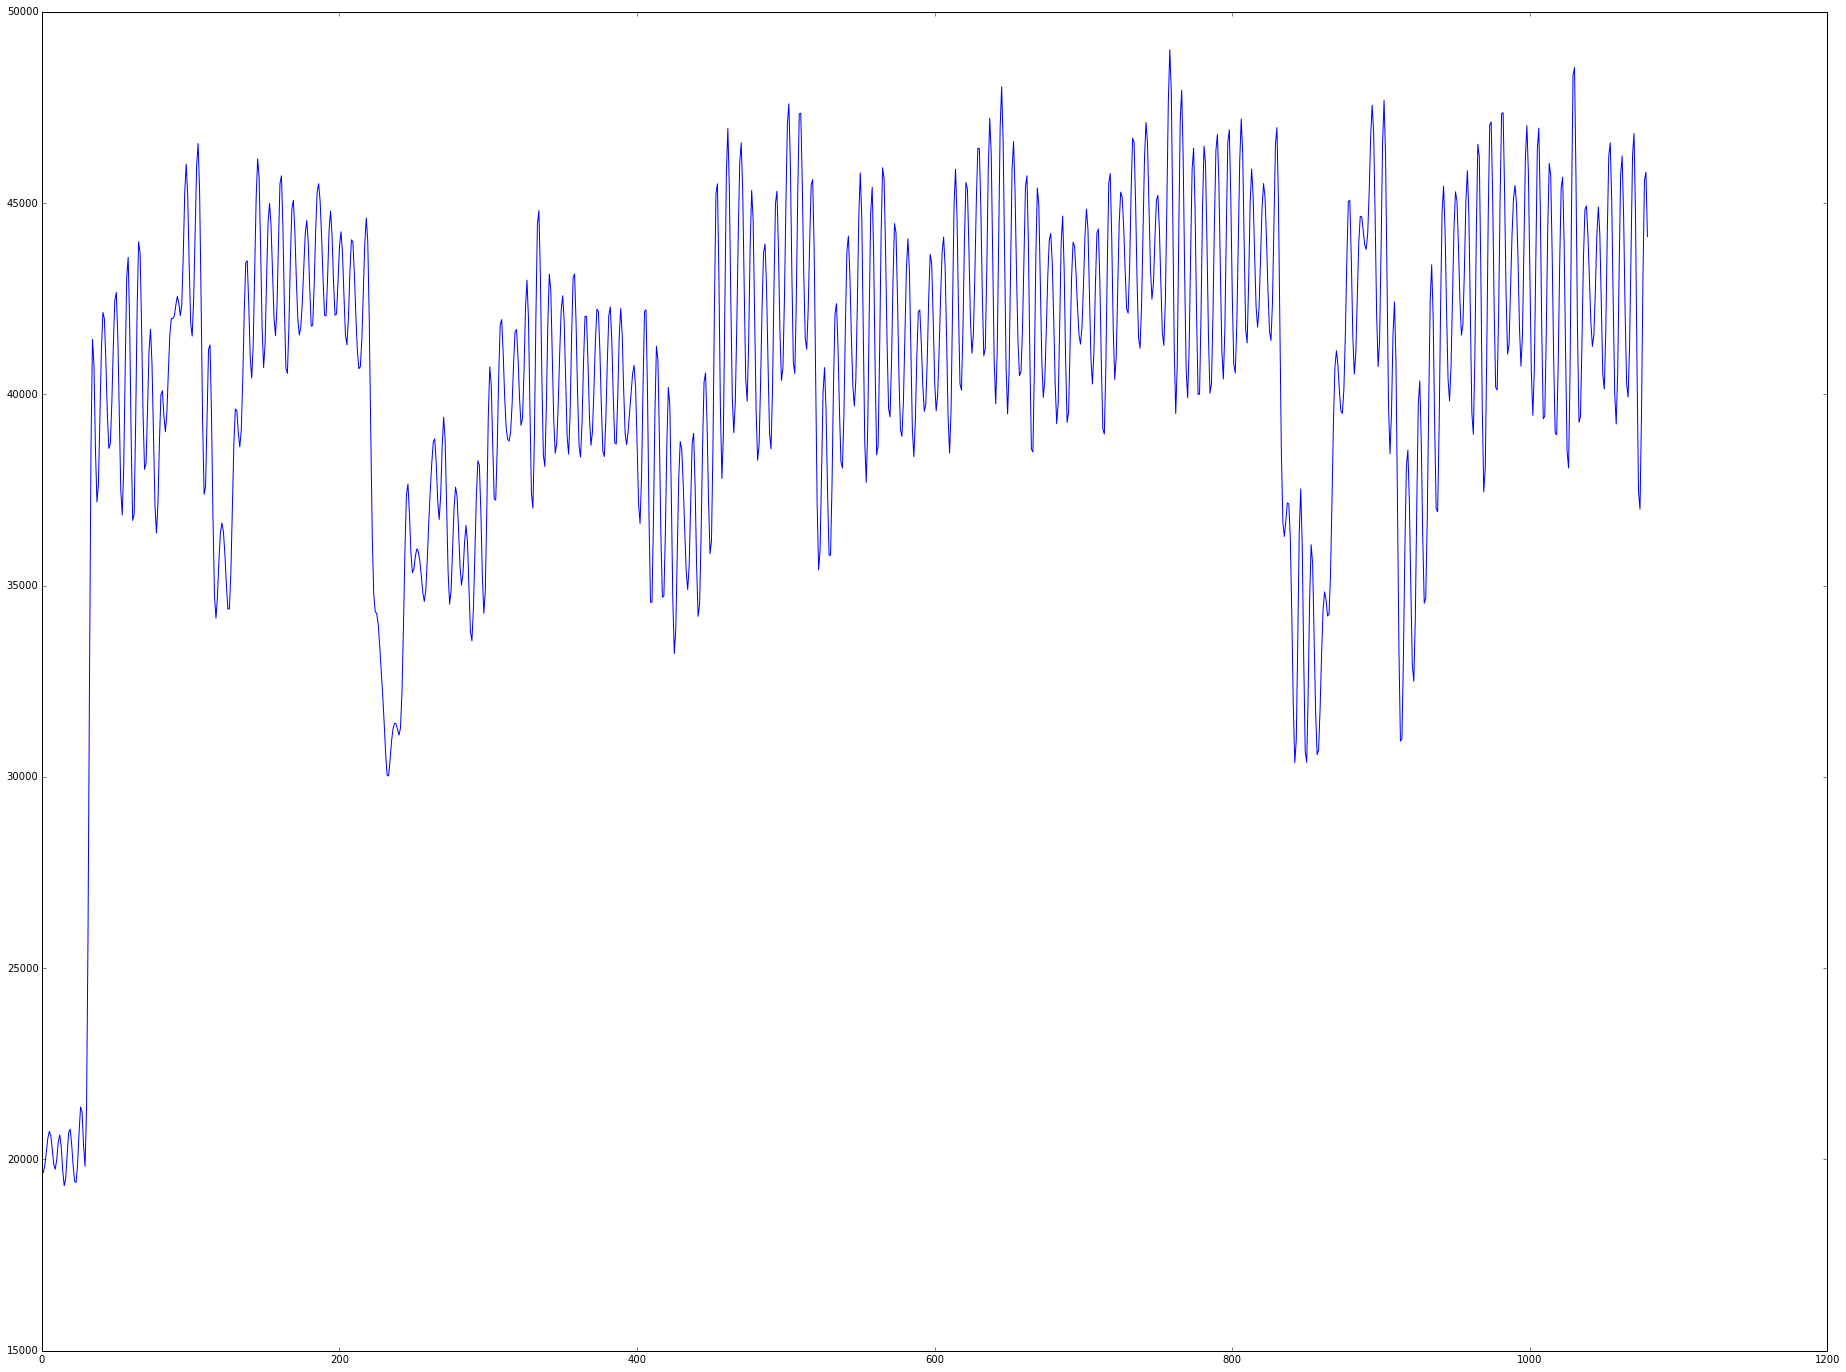

In [686]:
plt.plot(data[bbegin-500:bend+500])

In [692]:
burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [749]:
(1920 / 1820)

1.054945054945055